In [ ]:
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '688361.SH.csv'
draw_n_days = 400
df = hl.df_init(filename)

In [ ]:
# 完整测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=100, print_result=False, show_plot=True, save_plot=False)

In [ ]:
# 对上方得到的data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
data.plot(x='TRADE_DT', y='S_DQ_CLOSE', figsize=(20, 10))
# 对data进行DFT变换
data_fft = fft(data['S_DQ_CLOSE'].values)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_fft)
plt.show()
# 计算频谱中的总能量，并计算高频成分所占的比例。如果高频成分所占比例较小，那么曲线就比较平滑。
# 计算频谱中的总能量
energy = (data_fft * np.conj(data_fft)).real
# 计算高频成分所占的比例
high_freq_ratio = np.sum(energy[10:]) / np.sum(energy)
print(high_freq_ratio)
# 对高频成分进行滤波
data_fft_filtered = data_fft.copy()
data_fft_filtered[15:] = 0
# 对滤波后的数据进行逆变换
data_filtered = ifft(data_fft_filtered)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_filtered)
plt.show()

In [ ]:
# 对data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
# 将data等分为20份，对每份按照上述方法求的高频成分所占比例
n = 20
data_list = np.array_split(data, n)
high_freq_ratio_list = []
for temp_data in data_list:
    data_fft = fft(temp_data['S_DQ_CLOSE'].values)
    energy = (data_fft * np.conj(data_fft)).real
    high_freq_ratio = np.sum(energy[3:]) / np.sum(energy)
    high_freq_ratio_list.append(high_freq_ratio)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(high_freq_ratio_list)
plt.show()
print(high_freq_ratio_list)
# 使用plt.axvspan将高频成分占比可视化到data曲线上，高频占比越高的区域颜色越深
plt.figure(figsize=(20, 10))
plt.plot(data['S_DQ_CLOSE'].values)
for i in range(len(high_freq_ratio_list)):
    plt.axvspan(i * 10, (i + 1) * 10, facecolor='r',
                alpha=high_freq_ratio_list[i] * 100)

---

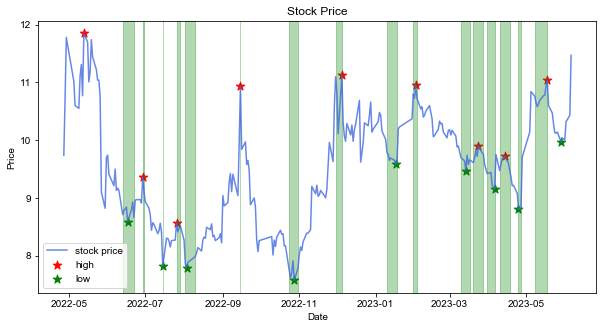

(413, 2769)

In [27]:
# hl median测试
filename = '000015.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw=False)
result = ha.find_ha_near_hl_median(df, high_points, low_points, 0.03)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=270, print_result=False, show_plot=True, save_plot=False)

In [ ]:
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
rr = pd.DataFrame(ha.cal_diff_rate_between_medians(result))
rr.columns = ['change_rate']
rr['flag'] = rr['change_rate'].apply(lambda x: '上涨' if x >= 0 else '下跌')
rr['change_rate'] = rr['change_rate']*100
rr

In [ ]:
# 绘制result中位数的boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['figure.figsize'] = [5, 10]
sns.boxplot(x='flag', y='change_rate', data=rr)
plt.show()
# 绘制histogram
plt.rcParams['figure.figsize'] = [7,5]
sns.histplot(data=rr, x='change_rate', hue='flag', bins=40)


In [ ]:
rr.hist()

  1%|          | 51/5406 [00:36<32:19,  2.76it/s]  

688361.SH.csv no high points
688361.SH.csv no low points


100%|██████████| 5406/5406 [01:17<00:00, 69.71it/s] 
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 28072 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/kai/opt/anaconda3

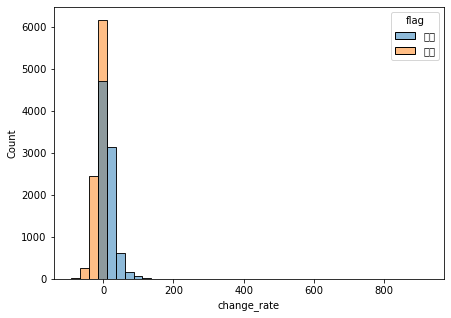

In [1]:
import pandas as pd
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

count = 0
cr_all = pd.DataFrame()
data_directory = '/Users/kai/Desktop/qs/data_csv_distinct_0606'
for filename in tqdm(os.listdir(data_directory)):
    if filename.endswith('.csv') & (count<100):
        df = hl.df_init(filename)

        high_points, low_points = hl.find_high_low(
            df, filename, save_data=False, draw=False)
        if pd.DataFrame(high_points).empty:
            print(filename, 'no high points')
        if pd.DataFrame(low_points).empty:
            print(filename, 'no low points')
        result = ha.find_ha_near_hl_median(df, high_points, low_points, 0.03)
        # ha.draw_horizontal_area(df, result, high_points, low_points, filename,
        #                         n_days=400, print_result=False, show_plot=True, save_plot=False)
        change_rate = pd.DataFrame(ha.cal_diff_rate_between_medians(result))
        if change_rate.empty:
            continue
        change_rate.columns = ['change_rate']
        change_rate['flag'] = change_rate['change_rate'].apply(lambda x: '上涨' if x >= 0 else '下跌')
        change_rate['change_rate'] = change_rate['change_rate']*100
        cr_all = cr_all.append(change_rate)
        count+=1

# 重置index
cr_all.reset_index(drop=True, inplace=True)
plt.rcParams['figure.figsize'] = [7,5]
sns.histplot(data=cr_all, x='change_rate', hue='flag', bins=40)
plt.show()


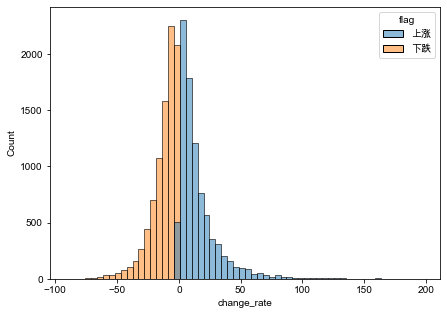

In [16]:
plt.rcParams['figure.figsize'] = [7,5]
# 去除异常值
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
cr_all = cr_all[cr_all['change_rate']<200]
sns.histplot(data=cr_all, x='change_rate', hue='flag', bins=60)
plt.show()

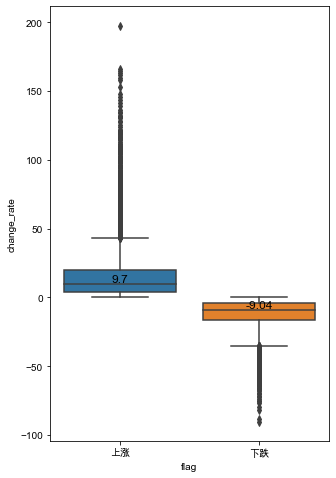

In [12]:
plt.rcParams['figure.figsize'] = [5, 8]
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
# 绘制boxplot并在图中每个box中位数上用文字写出数值
sns.boxplot(x='flag', y='change_rate', data=cr_all)
for i in range(len(cr_all.groupby('flag'))):
    plt.text(i, cr_all.groupby('flag')['change_rate'].median()[i], 
             round(cr_all.groupby('flag')['change_rate'].median()[i], 2), 
             ha='center', va='bottom', fontsize=12)
plt.show()

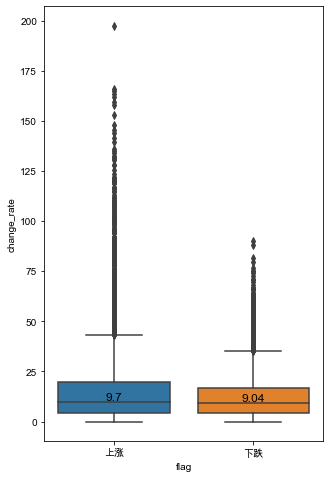

In [17]:
cr_all['change_rate'] = abs(cr_all['change_rate'])
plt.rcParams['figure.figsize'] = [5, 8]
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
# 绘制boxplot并在图中每个box中位数上用文字写出数值
sns.boxplot(x='flag', y='change_rate', data=cr_all)
for i in range(len(cr_all.groupby('flag'))):
    plt.text(i, cr_all.groupby('flag')['change_rate'].median()[i], 
             round(cr_all.groupby('flag')['change_rate'].median()[i], 2), 
             ha='center', va='bottom', fontsize=12)
plt.show()

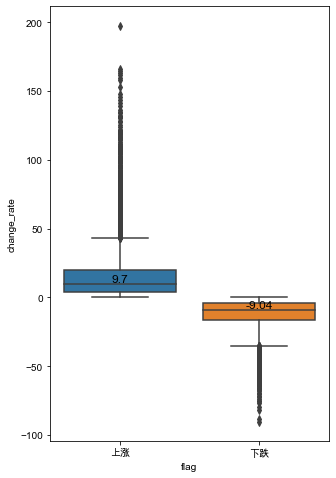

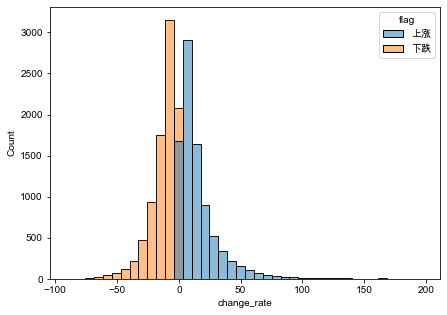

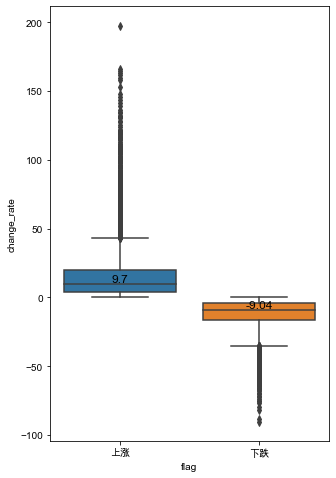

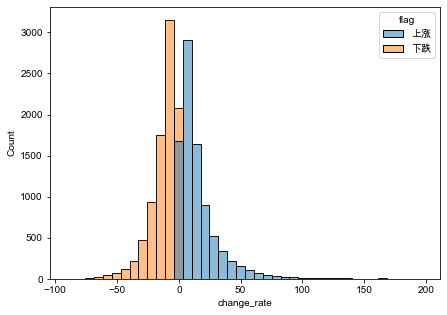

In [3]:
# 去除cr_all中的异常值
cr_all = cr_all[cr_all['change_rate']<200]
ha.draw_medians_all(cr_all)